# 1.Data Exploration

## 1.1.Establishing a Connection

We start by importing all necessary libraries

In [1]:
from py2neo import Graph # to connect to our neo4j Graph database
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import itertools

Connect to running instance of Neo4J

In [2]:
graph_url = "http://localhost:7474/db/data"
graph = Graph(graph_url)

Test the connection by returning, for example, some of the countries in the database. 

In [3]:
test_query = """    MATCH (n:Country) 
                    WITH n.name AS Country 
                    RETURN Country
                    LIMIT 10;   """

DataFrame(graph.data(test_query))

,Country
0,Australia
1,Belgium
2,United States of America
3,Brazil
4,Canada
5,Poland
6,Germany
7,Finland
8,People's Republic of China
9,Czech Republic


For another test, let us see the number of publications over the years in the database.

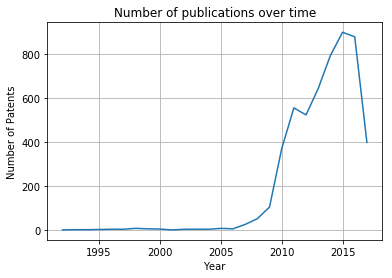

In [4]:
# query 
date_query = """ MATCH (n:PUBLICATION)
                RETURN labels(n), n.year, count(*)
                ORDER BY n.year
                """
# Extract number of publications and years, remove last entry because its "Null"
matrix = DataFrame(graph.data(date_query)).as_matrix()
dates =  matrix[:, 2][0:-1]
numbers = matrix[:, 0][0:-1]

# plot 
plt.title("Number of publications over time")
plt.xlabel("Year")
plt.ylabel("Number of Patents")
plt.plot(dates, numbers)
plt.grid()
plt.show()

## 1.2.Creating the global matrix

The goal of this part is to create a frequency matrix. As mentioned in the first meeting. 

This frequency matrix has the following items: 
* Feedstock
* Processing Tech
* Output

Furthermore, the matrix should be standardized. 

Make query

In [5]:
query = """ MATCH p1=(feed:Feedstock)<-[:CONTAINS]-(a1:Asset)-[:CONTAINS]->(proc:ProcessingTech)
            MATCH p2=(proc:ProcessingTech)<-[:CONTAINS]-(a1:Asset)-[:CONTAINS]->(out:Output) 
            WITH feed.term AS Feedstock, proc.term AS Processing_Technology, out.term AS Output, count(p1) AS count 
            RETURN Feedstock, Processing_Technology, Output, count 
            ORDER BY count
            DESC LIMIT 45""" # DESC LIMIT 300
data = DataFrame(graph.data(query)).as_matrix()

Create the axis of the matrix

In [6]:
feedstock = set(list(data[:, 0]))
processing_technology = set(list(data[:, 1]))
output = set(list(data[:, 2]))

matrix_axis = list(feedstock) + list(processing_technology) + list(output)

Build Matrix 

In [7]:
# initialize matrix
matrix = np.zeros([len(matrix_axis), len(matrix_axis)])

# find index of element in a given list
def find_index(element, in_list):
    return in_list.index(element)

# for every row in original response
for row in data:
    # the last column is the frequency
    frequency = row[-1]
    indexes = [find_index(element, matrix_axis) for element in row[0:-1]]
    # add frequency value to matrix position
    for pair in itertools.combinations(indexes, 2):
        matrix[pair[0], pair[1]] += frequency
        matrix[pair[1], pair[0]] += frequency

Let us normalize and visualize the matrix as a heatmap

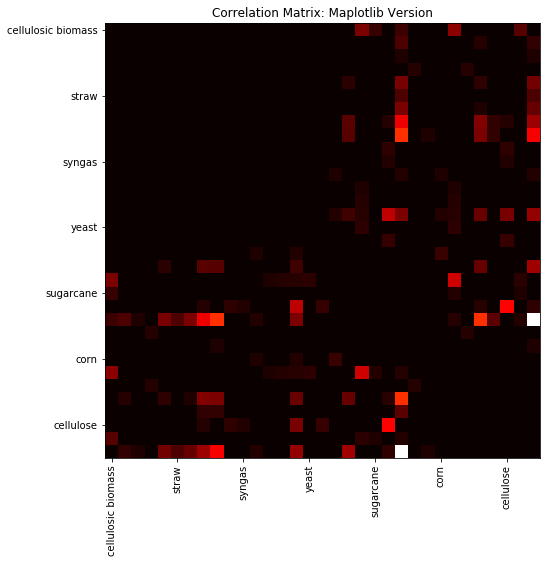

In [8]:
# normalize matrix using scipy normalization available here: http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization
normalized_matrix = (matrix - np.mean(matrix)) / np.std(matrix)

# plot a heatmap of the matrix
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(normalized_matrix, cmap='hot', interpolation='none') # plt.cm.Reds # normalization affects simmetry. 
ax.set_xticklabels(matrix_axis)
ax.set_yticklabels(matrix_axis)
plt.title("Correlation Matrix: Maplotlib Version")
plt.xticks(rotation=90) 
plt.show()

Let us see if seaborn can make this prettier. 

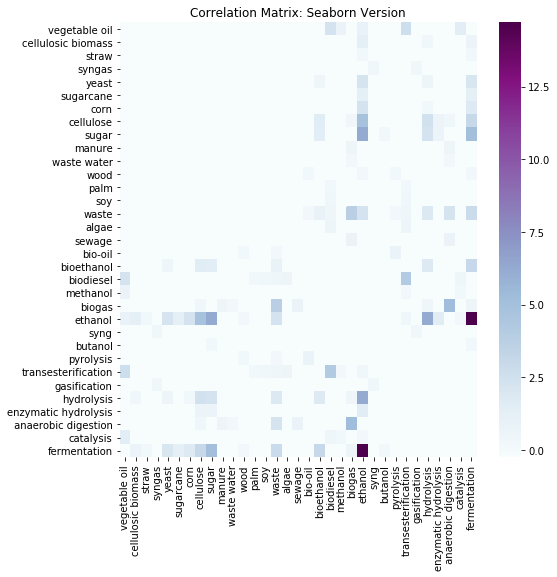

In [9]:
import seaborn as sns

# plot a heatmap of the matrix
fig, ax = plt.subplots(figsize=(8,8))
r = sns.heatmap(normalized_matrix, cmap='BuPu')
ax.set_xticklabels(matrix_axis)
ax.set_yticklabels(matrix_axis)
plt.title("Correlation Matrix: Seaborn Version")
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.show()

## 1.3. How does the matrix change from country to country? 

In this part of the exploration we will try to compare the "frequency matrix" of two countries. 

We start by creating a function that given a country, returns its correlation matrix. 

In [10]:
def get_the_matrix_from(country):
    query = """ MATCH p1=(feed:Feedstock)<-[:CONTAINS]-(a1:Asset)-[:CONTAINS]->(proc:ProcessingTech)
            MATCH p2=(proc:ProcessingTech)<-[:CONTAINS]-(a1:Asset)-[:CONTAINS]->(out:Output) 
            MATCH (a1:Asset)-[:LOCATED_IN]->(country:Country) 
            WHERE country.name = "{}" 
            WITH feed.term AS Feedstock, proc.term AS Processing_Technology, out.term AS Output, count(p1) AS count 
            RETURN Feedstock, Processing_Technology, Output, count 
            ORDER BY count DESC LIMIT 300 """.format(country)
    
    data = DataFrame(graph.data(query)).as_matrix()

    
    # initialize matrix
    matrix = np.zeros([len(matrix_axis), len(matrix_axis)])

    # for every row in original response
    for row in data:
        # the last column is the frequency
        frequency = row[-1]
        indexes = [find_index(element, matrix_axis) for element in row[0:-1] if element in matrix_axis]
        for pair in itertools.combinations(indexes, 2):
            matrix[pair[0], pair[1]] += frequency
            matrix[pair[1], pair[0]] += frequency
        
    
    # normalize matrix using scipy normalization available here: http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization
    normalized_matrix = normalized_matrix = (matrix - np.mean(matrix)) / np.std(matrix)
    
    return normalized_matrix

After definning the function, we apply it to two countries. 

In [30]:
country1 = 'United States of America'
country2 = 'Brazil'
country3 = 'Denmark'
country4 = 'Norway'

country1_matrix = get_the_matrix_from(country1)
country2_matrix = get_the_matrix_from(country2)
country3_matrix = get_the_matrix_from(country3)
country4_matrix = get_the_matrix_from(country4)

After applying the function to the countries, the results are plotted. 

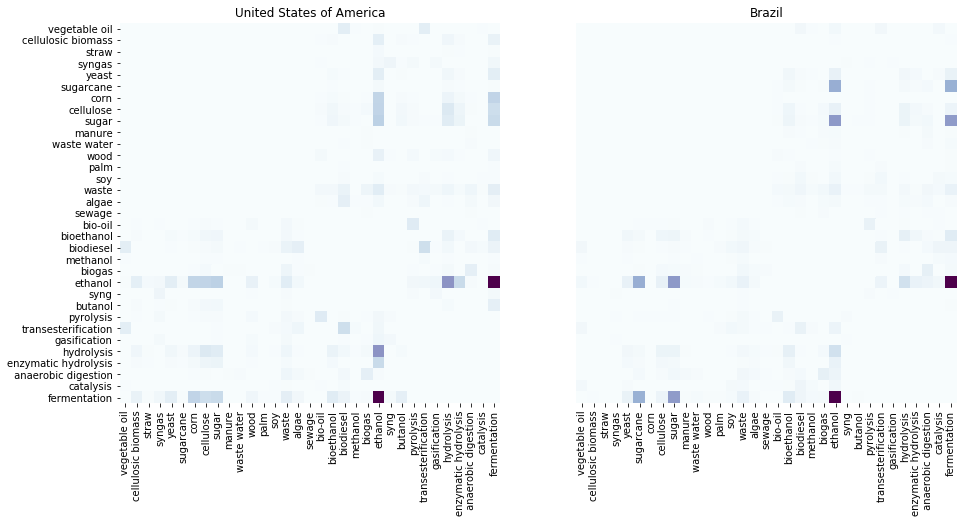

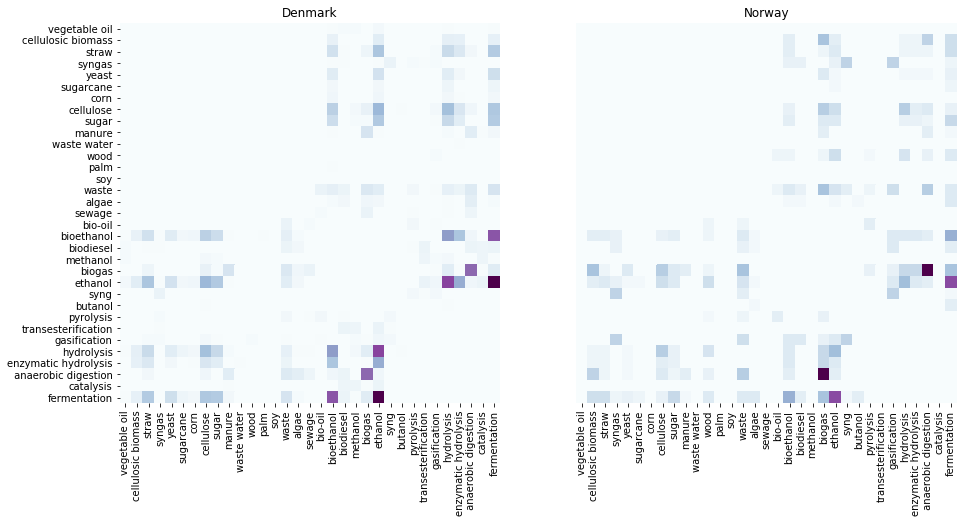

In [33]:
# first row
plt.subplots(2,1,figsize=(15,15))

plt.subplot(121)
sns.heatmap(country1_matrix, cmap='BuPu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=matrix_axis)
plt.title('{}'.format(country1))

plt.subplot(122)
sns.heatmap(country2_matrix, cmap='BuPu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=False)
plt.title('{}'.format(country2))
plt.show()

#second row
plt.subplots(2,1,figsize=(15,15))

plt.subplot(121)
sns.heatmap(country3_matrix, cmap='BuPu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=matrix_axis)
plt.title('{}'.format(country3))

plt.subplot(122)
sns.heatmap(country4_matrix, cmap='BuPu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=False)
plt.title('{}'.format(country4))
plt.show()

## 1.4. How does the matrix change over time? 

After seeying how to matrix changes from country to country, it's also interesting to see how it changes from year to year. For example, is the country so focused on certain flows every year? 